In [1]:
import polars as pl
import requests, io, zipfile

## Before we start - Getting a larger data set

In [2]:
%%bash
ls -al data

total 0
drwxr-xr-x@ 2 bn8210wy  staff   64 Oct 21 09:36 .
drwxr-xr-x@ 9 bn8210wy  staff  288 Oct 21 09:36 ..


In [3]:
uber_538_zip_url = "https://github.com/fivethirtyeight/uber-tlc-foil-response/raw/refs/heads/master/uber-trip-data/uber-raw-data-janjune-15.csv.zip"

r = requests.get(uber_538_zip_url)
assert r.ok
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("./data")

In [4]:
%%bash
ls -al data

total 1077488
drwxr-xr-x@ 4 bn8210wy  staff        128 Oct 21 09:37 .
drwxr-xr-x@ 9 bn8210wy  staff        288 Oct 21 09:36 ..
drwxr-xr-x@ 3 bn8210wy  staff         96 Oct 21 09:37 __MACOSX
-rw-r--r--@ 1 bn8210wy  staff  551672691 Oct 21 09:37 uber-raw-data-janjune-15.csv


## Using `scan_csv` to create a `polars` lazy data frame.

#### `scan_csv` is used to create a lazy query of a data frame.

In [5]:
(lazy_uber_raw_data :=
 pl.scan_csv('./data/uber-raw-data-janjune-15.csv', try_parse_dates=True)
)

#### To actually see some data, we need to `collect` (eager)

In [6]:
lazy_uber_raw_data.head(10).collect()

Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
str,datetime[μs],str,i64
"""B02617""",2015-05-17 09:47:00,"""B02617""",141
"""B02617""",2015-05-17 09:47:00,"""B02617""",65
"""B02617""",2015-05-17 09:47:00,"""B02617""",100
"""B02617""",2015-05-17 09:47:00,"""B02774""",80
"""B02617""",2015-05-17 09:47:00,"""B02617""",90
"""B02617""",2015-05-17 09:47:00,"""B02617""",228
"""B02617""",2015-05-17 09:47:00,"""B02617""",7
"""B02617""",2015-05-17 09:47:00,"""B02764""",74
"""B02617""",2015-05-17 09:47:00,"""B02617""",249


#### Build a lazy query using (most) familiar data frame methods

In [7]:
(lazy_uber_raw_data
 .group_by('Dispatching_base_num', 'Affiliated_base_num')
 .agg(pl.len())
)

#### Use `collect` to get the result once the query is complete.

In [8]:
(lazy_uber_raw_data
 .group_by('Dispatching_base_num', 'Affiliated_base_num')
 .agg(pl.len())
 .collect()
)

Dispatching_base_num,Affiliated_base_num,len
str,str,u32
"""B02764""","""B02817""",449
"""B02765""","""B02285""",692
"""B02765""","""B02800""",184
"""B02682""","""B02016""",117
"""B02764""","""B02480""",778
…,…,…
"""B02617""","""B02763""",66
"""B02765""","""B02027""",18
"""B02765""","""B02814""",179


## Lazy data frames can be more efficient

### Let's time both the eager and lazy versions.

#### Eager Version

In [9]:
eager_agg = %timeit -n 5 -o pl.read_csv('./data/uber-raw-data-janjune-15.csv').group_by('Dispatching_base_num', 'Affiliated_base_num').agg(pl.len())

eager_agg

537 ms ± 8.56 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


<TimeitResult : 537 ms ± 8.56 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)>

#### Lazy version

In [10]:
lazy_agg = %timeit -n 5 -o pl.scan_csv('./data/uber-raw-data-janjune-15.csv').group_by('Dispatching_base_num', 'Affiliated_base_num').agg(pl.len()).collect()

lazy_agg

347 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


<TimeitResult : 347 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)>

In [11]:
print(f"""The eager version took {round(eager_agg.average - lazy_agg.average, 4)*1000}ms longer,
which was {round(eager_agg.average/lazy_agg.average, 2)} times longer.""")

The eager version took 190.20000000000002ms longer,
which was 1.55 times longer.


## Some ways that lazy data frame improve performance

### Eager data frames require first loading all the data in memory

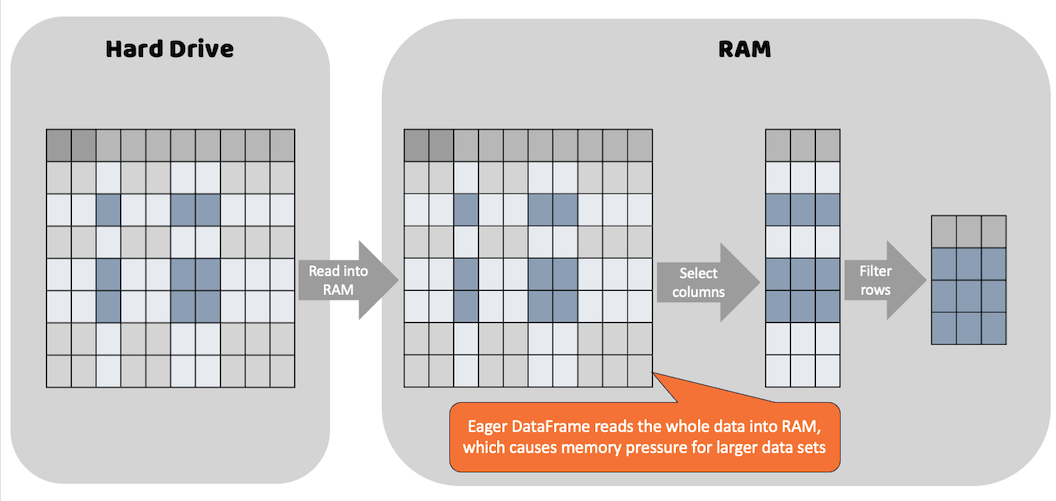

### Lazy data frames allow for important optimizations

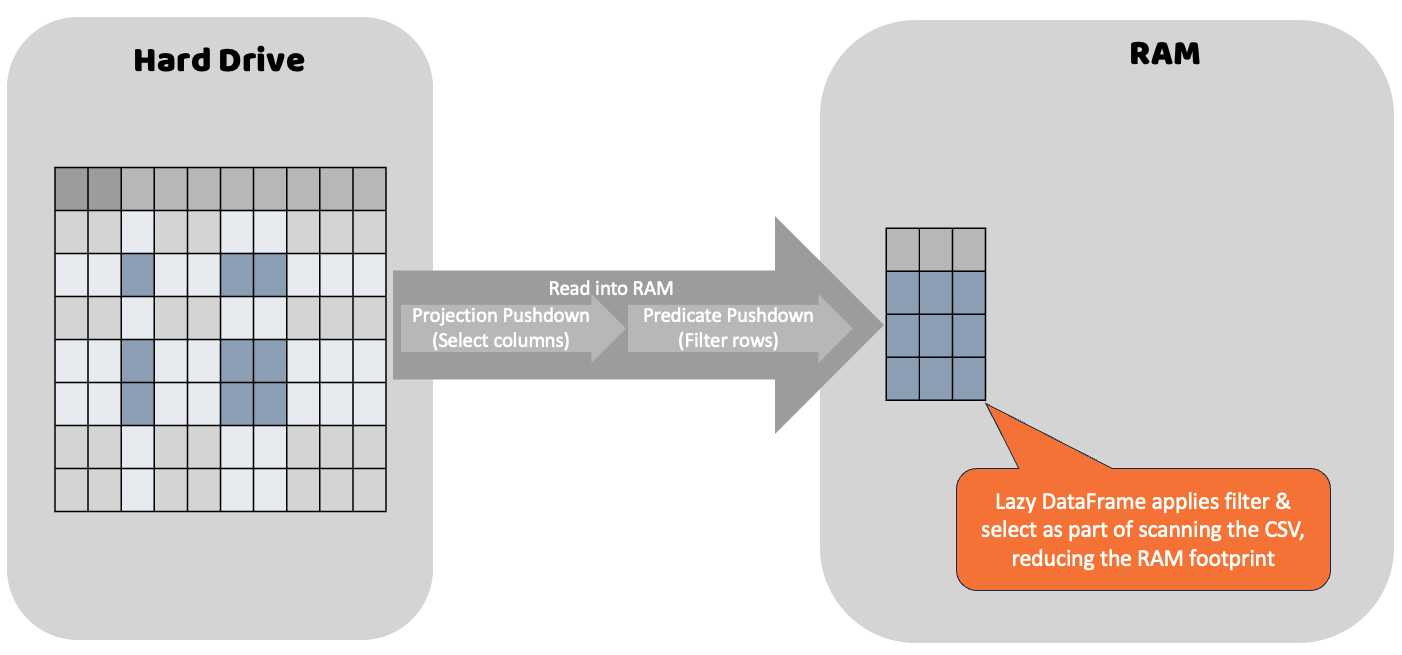

### Projection and predicate pushdown are only two of the `polars` optimizations

See the [`polars` documentation](https://docs.pola.rs/user-guide/lazy/optimizations/) for a list of some other optimizations, including
* **slice pushdown**,
* **join ordering** (optimal join order), and
* **Cardinality estimation** (optimal group-by strategy).

## Comparing the methods of eager and lazy data frames in `polars`

#### All methods in regular data frames

In [12]:
(eager_df_method :=
 set(m for m in dir(pl.read_csv('./data/uber-raw-data-janjune-15.csv')) if not m.startswith('_'))
)

{'approx_n_unique',
 'bottom_k',
 'cast',
 'clear',
 'clone',
 'collect_schema',
 'columns',
 'corr',
 'count',
 'describe',
 'deserialize',
 'drop',
 'drop_in_place',
 'drop_nulls',
 'dtypes',
 'equals',
 'estimated_size',
 'explode',
 'extend',
 'fill_nan',
 'fill_null',
 'filter',
 'flags',
 'fold',
 'gather_every',
 'get_column',
 'get_column_index',
 'get_columns',
 'glimpse',
 'group_by',
 'group_by_dynamic',
 'hash_rows',
 'head',
 'height',
 'hstack',
 'insert_column',
 'interpolate',
 'is_duplicated',
 'is_empty',
 'is_unique',
 'item',
 'iter_columns',
 'iter_rows',
 'iter_slices',
 'join',
 'join_asof',
 'lazy',
 'limit',
 'map_rows',
 'max',
 'max_horizontal',
 'mean',
 'mean_horizontal',
 'median',
 'melt',
 'merge_sorted',
 'min',
 'min_horizontal',
 'n_chunks',
 'n_unique',
 'null_count',
 'partition_by',
 'pipe',
 'pivot',
 'plot',
 'product',
 'quantile',
 'rechunk',
 'rename',
 'replace_column',
 'reverse',
 'rolling',
 'row',
 'rows',
 'rows_by_key',
 'sample',
 'sch

#### All methods in lazy data frames

In [13]:
(lazy_df_method :=
 set(m for m in dir(pl.scan_csv('./data/uber-raw-data-janjune-15.csv')) if not m.startswith('_'))
)

{'approx_n_unique',
 'bottom_k',
 'cache',
 'cast',
 'clear',
 'clone',
 'collect',
 'collect_async',
 'collect_schema',
 'columns',
 'count',
 'describe',
 'deserialize',
 'drop',
 'drop_nulls',
 'dtypes',
 'explain',
 'explode',
 'fetch',
 'fill_nan',
 'fill_null',
 'filter',
 'first',
 'gather_every',
 'group_by',
 'group_by_dynamic',
 'head',
 'inspect',
 'interpolate',
 'join',
 'join_asof',
 'last',
 'lazy',
 'limit',
 'map_batches',
 'max',
 'mean',
 'median',
 'melt',
 'merge_sorted',
 'min',
 'null_count',
 'pipe',
 'profile',
 'quantile',
 'rename',
 'reverse',
 'rolling',
 'schema',
 'select',
 'select_seq',
 'serialize',
 'set_sorted',
 'shift',
 'show_graph',
 'sink_csv',
 'sink_ipc',
 'sink_ndjson',
 'sink_parquet',
 'slice',
 'sort',
 'sql',
 'std',
 'sum',
 'tail',
 'top_k',
 'unique',
 'unnest',
 'unpivot',
 'update',
 'var',
 'width',
 'with_columns',
 'with_columns_seq',
 'with_context',
 'with_row_count',
 'with_row_index'}

#### Methods that are in common

In [14]:
(common_methods := 
 eager_df_method.intersection(lazy_df_method)
)

{'approx_n_unique',
 'bottom_k',
 'cast',
 'clear',
 'clone',
 'collect_schema',
 'columns',
 'count',
 'describe',
 'deserialize',
 'drop',
 'drop_nulls',
 'dtypes',
 'explode',
 'fill_nan',
 'fill_null',
 'filter',
 'gather_every',
 'group_by',
 'group_by_dynamic',
 'head',
 'interpolate',
 'join',
 'join_asof',
 'lazy',
 'limit',
 'max',
 'mean',
 'median',
 'melt',
 'merge_sorted',
 'min',
 'null_count',
 'pipe',
 'quantile',
 'rename',
 'reverse',
 'rolling',
 'schema',
 'select',
 'select_seq',
 'serialize',
 'set_sorted',
 'shift',
 'slice',
 'sort',
 'sql',
 'std',
 'sum',
 'tail',
 'top_k',
 'unique',
 'unnest',
 'unpivot',
 'update',
 'var',
 'width',
 'with_columns',
 'with_columns_seq',
 'with_row_count',
 'with_row_index'}

#### Eager-only methods

In [15]:
(eager_only_methods :=
 eager_df_method.difference(lazy_df_method)
)

{'corr',
 'drop_in_place',
 'equals',
 'estimated_size',
 'extend',
 'flags',
 'fold',
 'get_column',
 'get_column_index',
 'get_columns',
 'glimpse',
 'hash_rows',
 'height',
 'hstack',
 'insert_column',
 'is_duplicated',
 'is_empty',
 'is_unique',
 'item',
 'iter_columns',
 'iter_rows',
 'iter_slices',
 'map_rows',
 'max_horizontal',
 'mean_horizontal',
 'min_horizontal',
 'n_chunks',
 'n_unique',
 'partition_by',
 'pivot',
 'plot',
 'product',
 'rechunk',
 'replace_column',
 'row',
 'rows',
 'rows_by_key',
 'sample',
 'shape',
 'shrink_to_fit',
 'style',
 'sum_horizontal',
 'to_arrow',
 'to_dict',
 'to_dicts',
 'to_dummies',
 'to_init_repr',
 'to_jax',
 'to_numpy',
 'to_pandas',
 'to_series',
 'to_struct',
 'to_torch',
 'transpose',
 'unstack',
 'upsample',
 'vstack',
 'write_avro',
 'write_clipboard',
 'write_csv',
 'write_database',
 'write_delta',
 'write_excel',
 'write_ipc',
 'write_ipc_stream',
 'write_json',
 'write_ndjson',
 'write_parquet'}

#### Lazy-only methods

In [16]:
(lazy_only_methods :=
 lazy_df_method.difference(eager_df_method)
)

{'cache',
 'collect',
 'collect_async',
 'explain',
 'fetch',
 'first',
 'inspect',
 'last',
 'map_batches',
 'profile',
 'show_graph',
 'sink_csv',
 'sink_ipc',
 'sink_ndjson',
 'sink_parquet',
 'with_context'}

## <font color="red"> Exercise 4.1 </font>

Suppose that we want to compute the number of trips on each day of the week, but only when the dispatch station is Unter (Code `B02512`; see the 538 [github page](https://github.com/fivethirtyeight/uber-tlc-foil-response/tree/master?tab=readme-ov-file) README) and only during the regular work week and not the weekend.  

To do this, we need to
1. Filter to only the work week (do this in one expression to allow predicate pushdown,
2. Select the dispatch column and day of the week column,
3. Compute the day of the week form the pick up date column, and
4. Group and aggregate to get the daily counts.

**Your task.** Try performing this with both the eager and lazy data frames.  Time the results of each and comment on differences.

In [17]:
# Your eager code here

In [18]:
# Your lazy code here